In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

## Data preprocessing of the dataset CIFAR-10

In [9]:
# @title Data preprocessing for Cifar-10 Dataset

batch_dir = "dataset/cifar-10-batches-py"
batches_meta_file = "dataset/cifar-10-batches-py/batches.meta"

def dump_batches():
    n_train_batches = 5
    
    for idx in range(1, n_train_batches + 1):
        labels, imgs = load_train_batch(batch_dir, idx)
        norm_imgs = normalize(imgs, 0.0, 255.0)
        encoded_labels = one_hot_encode(labels)
        
        file = 'dataset/prep/prep_batch_' + str(idx) + '.pickle'
        with open(file, 'wb') as f:
            pickle.dump((encoded_labels, norm_imgs), f)
    
    labels, imgs = load_test_batch(batch_dir)
    norm_imgs = normalize(imgs, 0.0, 255.0)
    encoded_labels = one_hot_encode(labels)
    
    file = 'dataset/prep/prep_test_batch.pickle'
    with open(file, 'wb') as f:
            pickle.dump((encoded_labels, norm_imgs), f)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_train_batch(batch_dir, i):
    batch_i = unpickle(batch_dir + '/data_batch_' + str(i))
    labels = batch_i[b'labels']
    data = batch_i[b'data']
    imgs = data.reshape(len(data), 3, 32, 32).transpose(0,2,3,1)
    return labels, imgs

def load_test_batch(batch_dir):
    test_batch = unpickle(batch_dir + '/test_batch')
    labels = test_batch[b'labels']
    data = test_batch[b'data']
    imgs = data.reshape(len(data), 3, 32, 32).transpose(0,2,3,1)
    return labels, imgs
    

def load_labels():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_img(imgs, idx, labels, label_names):
    img = imgs[idx]
    label = np.argmax(labels[idx])
    category = label_names[label]
    print("Category of the image is {}".format(category))
    plt.imshow(img)
    
def normalize(x, min, max):
    return (x - min)/(max - min)

def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    return encoded

Category of the image is automobile


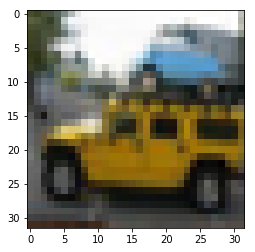

In [10]:
label_names = load_labels()
labels, imgs = load_train_batch(batch_dir, 1)
labels = one_hot_encode(labels)
norm_imgs = normalize(imgs, 0, 255.0)
show_img(norm_imgs, 9997, labels, label_names)

In [ ]:
dump_batches()

## Convolutional Neural Network

Category of the image is ship


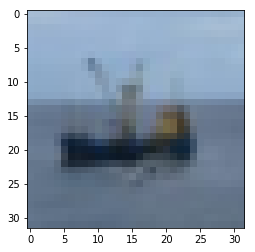

In [4]:
prep_batch_dir = 'dataset/prep'
batch_1 = prep_batch_dir + '/prep_batch_1.pickle'
with open(batch_1, 'rb') as f:
    batch_1_labels, batch_1_imgs = pickle.load(f, encoding='bytes')
    
show_img(batch_1_imgs, 554, batch_1_labels, label_names)

In [15]:
input_layer = batch_1_imgs[0]
print(input_layer)
print(input_layer.shape)
print(input_layer[0:0+2][2:2+2])
print("Loop Start")
kernel_size = 3
kernel = np.ones((3, 3, 3))
row_kernel = kernel.reshape(1, -1)

n_pos_width = input_layer.shape[0] - kernel_size + 1
n_pos_height = input_layer.shape[1] - kernel_size + 1
print(n_pos_width, n_pos_height)

for height in range(0, n_pos_height):
    print(height)
    for width in range(0, n_pos_width):
        print(width)
        recept_field = input_layer[width:width+3][height:height+3]
        print(recept_field)
        
print(input_layer[0:0+2][2:2+2])

[[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]
  [0.67843137 0.48235294 0.16470588]


  [0.20784314 0.13333333 0.07843137]]]
28
[[[0.8627451  0.71372549 0.35686275]
  [0.78823529 0.58823529 0.08627451]
  [0.72941176 0.58039216 0.09411765]
  [0.6745098  0.54509804 0.10980392]
  [0.61176471 0.47058824 0.10196078]
  [0.55686275 0.40392157 0.11764706]
  [0.55686275 0.39215686 0.2       ]
  [0.6        0.42352941 0.29411765]
  [0.58823529 0.41176471 0.28627451]
  [0.54509804 0.38431373 0.22352941]
  [0.49411765 0.34509804 0.14901961]
  [0.53333333 0.36078431 0.18431373]
  [0.58039216 0.4        0.24313725]
  [0.55294118 0.39607843 0.23529412]
  [0.51372549 0.34901961 0.2       ]
  [0.49411765 0.32156863 0.19215686]
  [0.49803922 0.31764706 0.2       ]
  [0.54117647 0.34509804 0.20392157]
  [0.58823529 0.39215686 0.23529412]
  [0.60392157 0.40784314 0.25490196]
  [0.58431373 0.39607843 0.23529412]
  [0.48627451 0.30588235 0.14117647]
  [0.49411765 0.33333333 0.16078431]
  [0.55294118 0.39607843 0.21568627]
  [0.56862745 0.41960784 0.23921569]
  [0.57647059 0.43921569 0.266666

  [0.36862745 0.24313725 0.1372549 ]]]
2
[[[0.19607843 0.1254902  0.08235294]
  [0.23137255 0.1254902  0.04313725]
  [0.4        0.25490196 0.13333333]
  [0.49803922 0.30980392 0.15294118]
  [0.48627451 0.30196078 0.14117647]
  [0.4745098  0.30196078 0.14117647]
  [0.47058824 0.30588235 0.15686275]
  [0.44705882 0.29019608 0.15294118]
  [0.41960784 0.28235294 0.13333333]
  [0.49019608 0.34509804 0.19215686]
  [0.50588235 0.34901961 0.2       ]
  [0.41568627 0.26666667 0.12156863]
  [0.42352941 0.27843137 0.12941176]
  [0.48627451 0.3254902  0.16470588]
  [0.4745098  0.30588235 0.15294118]
  [0.42352941 0.26666667 0.11372549]
  [0.38431373 0.25490196 0.09019608]
  [0.43137255 0.29019608 0.14509804]
  [0.45882353 0.31372549 0.19215686]
  [0.47058824 0.31372549 0.16078431]
  [0.5254902  0.36470588 0.19607843]
  [0.54901961 0.41568627 0.25882353]
  [0.51372549 0.37254902 0.22745098]
  [0.55294118 0.38431373 0.25882353]
  [0.52941176 0.36078431 0.2       ]
  [0.49803922 0.32941176 0.1764705

[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
16
0
[]
1
[]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
17
0
[]
1
[]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
18
0
[]
1
[]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
19
0
[]
1
[]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
20
0
[]
1
[]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
21
0
[]
1
[]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
1